In [1]:
import torch
import numpy as np
import einx
import torchvision
import torchvision.transforms as transforms
from diffusion import Diffusion, UnetConfig
import lightning
from lightning.fabric import Fabric
from pytorch_lightning.utilities.model_summary import ModelSummary
from torch import nn
import torch.nn.functional as F
from typing import Any
from torch.utils import data
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\rahar\anaconda3\envs\neuro\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rahar\anaconda3\envs\neuro\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## Loading MNIST

In [2]:
BATCH_SIZE = 32
DEVICE = "cuda"
torch.set_float32_matmul_precision('medium')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True,
											  drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False,
												drop_last=True)

## DDPM sampler

In [4]:
class DDPMSampler:

	def __init__(self,
			  generator:torch.Generator,
			  num_training_steps=1000,
			  beta_start:float = 0.00085,
			  beta_end:float = 0.0120,):
		
		# scaled linear schedule
		self.betas = torch.linspace(beta_start**0.5,beta_end**0.5,num_training_steps,dtype=torch.float32)**2
		self.alphas = 1.0 - self.betas

		self.alpha_cumprod = torch.cumprod(self.alphas,0)
		self.one = torch.tensor(1.0)
		self.zero = torch.tensor(0.0)

		self.generator = generator
		self.num_training_steps = num_training_steps
		
		self.timesteps = torch.arange(num_training_steps).flip(-1)

	def add_get_noise(self,
				   original_samples:torch.FloatTensor,
				   timesteps:torch.IntTensor):
		
		alpha_cumprod = self.alpha_cumprod.to(device=original_samples.device,dtype=original_samples.dtype)
		time_steps = timesteps.to(original_samples.device)
		sqrt_alpha_cumprod = alpha_cumprod[timesteps]**0.5
		sqrt_alpha_cumprod = sqrt_alpha_cumprod.flatten()

		while len(sqrt_alpha_cumprod.shape) < len(original_samples.shape):
			sqrt_alpha_cumprod = sqrt_alpha_cumprod.unsqueeze(-1)

		sqrt_one_minus_alpha_cumprod = (1 - alpha_cumprod[timesteps])**0.5
		sqrt_one_minus_alpha_cumprod = sqrt_one_minus_alpha_cumprod.flatten()

		while len(sqrt_one_minus_alpha_cumprod.shape) < len(original_samples.shape):
			sqrt_one_minus_alpha_cumprod = sqrt_one_minus_alpha_cumprod.unsqueeze(-1)

		noise = torch.randn(original_samples.shape,generator=self.generator,
					  device=original_samples.device,dtype=original_samples.dtype)
	
		noisy_sample = sqrt_alpha_cumprod * original_samples + sqrt_one_minus_alpha_cumprod * noise
		return noisy_sample,noise
	
	def reverse_step(self,
				  timestep:int,
				  latents:torch.Tensor,
				  model_output:torch.Tensor,):
		
		t = timestep

		alpha_prod_t = self.alpha_cumprod[timestep]
		alpha_prod_t_prev = self.alpha_cumprod[timestep]

		alpha_t = self.alphas[timestep]

		sigma_t = ((1 - alpha_prod_t_prev)*(1 - alpha_t)/(1 - alpha_prod_t))**(0.5)

		image_scale = 1/(alpha_t**0.5)

		noise_scale = -(1-alpha_t)/(alpha_t*(1-alpha_prod_t))**(0.5)

		mean = image_scale*latents + noise_scale*model_output

		variance = 0
		
		if t> 0:
			device = model_output.device
			noise = torch.randn(model_output.shape,
				generator=self.generator,
				device=device,
				dtype=model_output.dtype)
			variance = sigma_t*noise

		x_t_prev = mean + variance

		return x_t_prev
		

## Setting up models

In [5]:
class IdentityModule(lightning.LightningModule):

	def __init__(self, *args: Any, **kwargs: Any) -> None:
		super().__init__(*args, **kwargs)

	def forward(self,x) -> Any:
		return x

In [6]:
class StandardDiffusion(lightning.LightningModule):

	def __init__(self,
			  diffusion_config:UnetConfig,
			  num_timesteps=1000):
		
		super().__init__()

		self.class_embedder = nn.Embedding(11,diffusion_config.d_context)
		self.encoder = IdentityModule()
		self.decoder = IdentityModule()
		self.diffusion = Diffusion(diffusion_config)
		self.generator = torch.Generator(device=DEVICE)
		self.sampler = DDPMSampler(self.generator,num_training_steps=num_timesteps)
		self.diffusion_config = diffusion_config
	
	def time_embed(self,timesteps):
		freqs = torch.pow(10000,
					 -torch.arange(start=0,
					 end=self.diffusion_config.time_dim // 2,
					 dtype=torch.float32) / (self.diffusion_config.time_dim // 2))

		# Expand timesteps to match frequency dimensions (Shape: (batch_size, TIME_DIM // 2))
		x = timesteps[:, None] * freqs[None, :].to(timesteps.device)

		# Concatenate sine and cosine embeddings (Shape: (batch_size, TIME_DIM))
		return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

	def diffusion_training_step(self,x,labels):
		b,c,h,w = x.shape

		t = torch.randint(0,self.sampler.num_training_steps,
					(b,),
					device=DEVICE,
					generator=self.generator)
		
		noisy_latent,noise = self.sampler.add_get_noise(x,t)

		time_embeds = self.time_embed(t)

		context = self.class_embedder(labels)

		predicted_noise = self.diffusion(noisy_latent,context,time_embeds)

		loss = F.mse_loss(predicted_noise,noise)
		return loss

In [7]:
mnist_normal_diffusion_config = UnetConfig(
	in_channels=1,
	n_downsample=2,
	init_dim=8,
	final_dim=32,
	n_heads=4,
	n_group=4,
	kernel_size=3,
	time_dim=320,
	d_context=32
)

In [8]:
normal_diff = StandardDiffusion(mnist_normal_diffusion_config,1000)

In [9]:
normal_diff.sampler.timesteps

tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 8

In [10]:
normal_diff.to(DEVICE)
ModelSummary(normal_diff)

  | Name           | Type           | Params
--------------------------------------------------
0 | class_embedder | Embedding      | 352   
1 | encoder        | IdentityModule | 0     
2 | decoder        | IdentityModule | 0     
3 | diffusion      | Diffusion      | 2.5 M 
--------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)

In [11]:
def diffusion_prep_batch(x,
						 y,
						 pdrop=0.2):
	y = y+1
	drop = torch.rand(y.shape)
	return x,y*(drop>pdrop)

In [12]:
def diffusion_train(fabric,
          model: StandardDiffusion,
          training_loader: data.DataLoader,
          n_train_steps: int,
          val_steps: int):
    
    n_steps = 0

    losses = []

    model = model.to(DEVICE)

    model.encoder.freeze()
    model.decoder.freeze()

    optimizer = torch.optim.AdamW(model.parameters(), lr=1E-3, weight_decay=1E-3)

    model,optimizer = fabric.setup(model,optimizer)
    
    training_losses = []
    
    while n_steps < n_train_steps:

        for batch in training_loader:
            with fabric.autocast():
                x, y = diffusion_prep_batch(*batch,pdrop=0.2)
                x = x.to(DEVICE)
                y = y.to(DEVICE)
                
                loss = model.diffusion_training_step(x,y)

            fabric.backward(loss)
            losses.append(loss.item())
            
            optimizer.step()
            model.zero_grad()
            
            n_steps += 1

            if n_steps % val_steps == 0:
                
                print(f"Training step: {n_steps}/{n_train_steps} | Loss: {np.mean(losses)}")
                
                training_losses.append(np.mean(losses))

                losses = []
                
            if n_steps >= n_train_steps:
                break

    return training_losses

In [13]:
fabric = Fabric(accelerator="cuda",precision="32-true")

In [14]:
diffusion_train(fabric,normal_diff,training_loader,5000,100)

Training step: 100/5000 | Loss: 0.2275781811028719
Training step: 200/5000 | Loss: 0.07547488734126091
Training step: 300/5000 | Loss: 0.05775517035275698
Training step: 400/5000 | Loss: 0.05091435264796019
Training step: 500/5000 | Loss: 0.04683008974418044
Training step: 600/5000 | Loss: 0.04532842598855495
Training step: 700/5000 | Loss: 0.04439096488058567
Training step: 800/5000 | Loss: 0.04149855595082044
Training step: 900/5000 | Loss: 0.04046943344175816
Training step: 1000/5000 | Loss: 0.039843745063990355
Training step: 1100/5000 | Loss: 0.03863750929012895
Training step: 1200/5000 | Loss: 0.03844166060909629
Training step: 1300/5000 | Loss: 0.03781624913215637
Training step: 1400/5000 | Loss: 0.03538321707397699
Training step: 1500/5000 | Loss: 0.03763116119429469
Training step: 1600/5000 | Loss: 0.03599358431994915
Training step: 1700/5000 | Loss: 0.03607528766617179
Training step: 1800/5000 | Loss: 0.03513506598770619
Training step: 1900/5000 | Loss: 0.035840705446898935
T

[0.2275781811028719,
 0.07547488734126091,
 0.05775517035275698,
 0.05091435264796019,
 0.04683008974418044,
 0.04532842598855495,
 0.04439096488058567,
 0.04149855595082044,
 0.04046943344175816,
 0.039843745063990355,
 0.03863750929012895,
 0.03844166060909629,
 0.03781624913215637,
 0.03538321707397699,
 0.03763116119429469,
 0.03599358431994915,
 0.03607528766617179,
 0.03513506598770619,
 0.035840705446898935,
 0.03478714955970645,
 0.03577675899490714,
 0.034300180319696665,
 0.034647830817848446,
 0.033093694671988486,
 0.03259767804294825,
 0.033247139044106006,
 0.03301745366305113,
 0.03205338021740317,
 0.033000184968113896,
 0.03381772147491574,
 0.03278613088652491,
 0.03271119767799974,
 0.03285798380151391,
 0.03340396551415324,
 0.03280821727588773,
 0.03275510404258966,
 0.03387454776093364,
 0.0317113402672112,
 0.032410802133381364,
 0.03124401306733489,
 0.03178396724164486,
 0.03158727722242474,
 0.03155533334240317,
 0.032476428039371966,
 0.030429855287075043,
 0

In [15]:
state_dict = normal_diff.state_dict()
torch.save(state_dict,"states.pt")

In [16]:
normal_diff.load_state_dict(torch.load("states.pt"))

<All keys matched successfully>

In [17]:
def get_time_embedding(timestep):
    # Shape: (160,)
    freqs = torch.pow(10000, -torch.arange(start=0, end=320//2, dtype=torch.float32) / (320//2)) 
    # Shape: (1, 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 160 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)


In [18]:
def mnist_gen(model:StandardDiffusion,
			  image_shape,
			  classes,
			  do_cfg=True,
			  cfg_scale=2,):
	
	n_imgs = len(classes)
	latent_shape = [n_imgs] + list(image_shape)

	latents = torch.randn(latent_shape,
		generator=model.generator,
		device=model.device)
	
	timesteps = tqdm(model.sampler.timesteps)

	if do_cfg:
		uncond_context = torch.zeros_like(classes)
		context = einx.rearrange("b1 ..., b2 ... -> (b1 + b2) ...",classes,uncond_context)
	else:
		context = classes

	context = model.class_embedder(context)

	for i,timestep in enumerate(timesteps):

		with torch.no_grad():
			time_embedding = get_time_embedding(timestep).to(model.device)

			model_inputs = einx.rearrange("b ... -> (k b) ...",latents,k=(1+do_cfg))

			model_output = model.diffusion(model_inputs,context,time_embedding)

			if do_cfg:
				output_cond,output_uncond = einx.rearrange("(k b) ... -> k b ...",model_output,k=2)
				model_output = cfg_scale * (output_cond - output_uncond) + output_uncond

			latents = model.sampler.reverse_step(timestep,latents,model_output)

	with torch.no_grad():
		images = model.decoder(latents)
	return images

In [19]:
x,y = diffusion_prep_batch(*next(iter(validation_loader)),pdrop=0)
x = x.to(DEVICE)
y = y.to(DEVICE)

In [20]:
diff_imgs = mnist_gen(normal_diff,x.shape[1:],
					  classes=y,cfg_scale=5,
					  do_cfg=True)

100%|██████████| 1000/1000 [00:38<00:00, 26.12it/s]


In [21]:
diff_imgs = diff_imgs.cpu().detach()

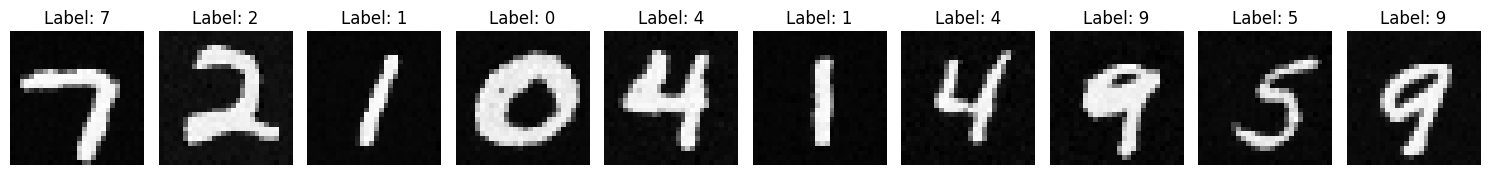

In [22]:
fig, axes = plt.subplots(1, 10, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(diff_imgs[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {y[i]-1}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()


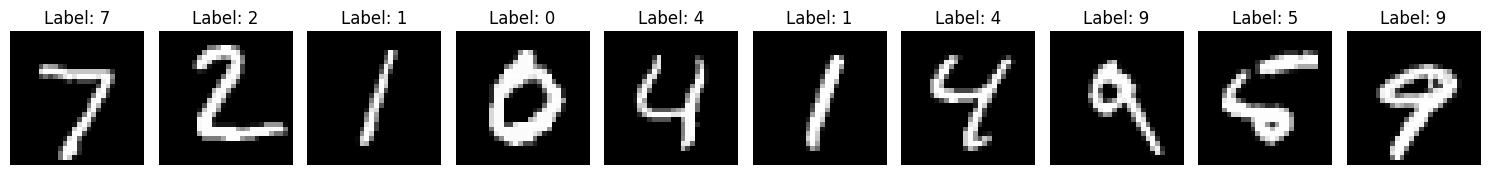

In [24]:
fig, axes = plt.subplots(1, 10, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(x[i].cpu().squeeze(), cmap='gray')
    ax.set_title(f'Label: {y[i]-1}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()
